In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns

Objetivos do Script:

Esse script tem como objetivo ler os dados que foram capturados da nossa amostra piloto e realizar alguns estudos em cima desses dados. 

Os 6 primeiros tópicos que eu separei abaixo são utilizados na grande maioria dos scripts de tratamento de dados desse estudo. 
Deixei padronizado para que seja possivel tratar simulações com um dispositivo ou vários.

Sumário:
  - Leitura dos dados
  - Separar publicações e confirmação de entrega por dispositivo simulado.
  - Criação de um dataframe com informações capturadas. 
  - Medidas de tendência centrar por dispositivo
  - Medidas de tendência centrar de todos os dispositivos.
  - Gráfico de dispersão da amostra.
  - Calculo do tamanho da amostra.

Como estamos trabalhando com uma amostra piloto temos como objetivo calcular o tamanho das amostras isso será realizado na ultima parte desse script.



In [3]:
# - Leitura dos dados

data = pd.read_csv("./data.csv")
ports = data["Source Port"].unique()
ports = ports[ports !=1883]

In [4]:
#  - Separar publicações e confirmação de entrega por dispositivo simulado.
devices = {}
#  : devices será um dicionario que irá ter uma chave referente ao device e o valor será um dataframe referente aos respectivos devices 
for port in ports:  
  array_publish = data.loc[data["Source Port"] == port].dropna(subset=['Message Identifier'])
  array_publish_ack = data.loc[data["Destination Port"] == port].dropna(subset=['Message Identifier'])
  device = {"publish":array_publish, "publish_ack" : array_publish_ack}
  devices[port] = device

In [5]:
# - Criação de um dataframe com informações capturadas acima. 
data = {}
for port in ports:
    RTT = pd.DataFrame(columns=["Time_publish", "Time_ack"])
    for index, row in devices[port]["publish"].iterrows():
        id = int(row["Message Identifier"])
        time_publish = row["Time"]
        RTT.loc[id, "Time_publish"] = time_publish 

    for index, row in devices[port]["publish_ack"].iterrows():
        id = int(row["Message Identifier"])
        time_publish = row["Time"]
        RTT.loc[id, "Time_ack"] = time_publish
    RTT.loc[id, "Time_ack"] = time_publish
    RTT["RTT"]  =(RTT["Time_ack"] - RTT["Time_publish"] )* 1000
    data[port] = RTT


## Medidas de Tendência Central Por Device

In [6]:
i=1
data_mean = []
data_median = []
data_std = []
data_min = []
data_max = []

for port in ports:
  data_mean.append(data[port]["RTT"].mean())
  data_median.append(data[port]["RTT"].mean())
  data_std.append(data[port]["RTT"].mean())
  data_min.append(data[port]["RTT"].mean())
  data_max.append(data[port]["RTT"].mean())

  print("(Device-{})Mean Round Trip Time = {}".format(i ,data[port]["RTT"].mean()))
  print("(Device-{})Median Round Trip Time = {}".format(i ,data[port]["RTT"].median()))
  print("(Device-{})Standard deviation  Round Trip Time = {}".format(i ,data[port]["RTT"].std()))
  print("(Device-{})Min Round Trip Time = {}".format(i ,data[port]["RTT"].min()))
  print("(Device-{})Max Round Trip Time = {}".format(i ,data[port]["RTT"].max()))
  print("---------------------------------------------------------------")

  i+=1

(Device-1)Mean Round Trip Time = 2.794579920265673
(Device-1)Median Round Trip Time = 2.6867750000008073
(Device-1)Standard deviation  Round Trip Time = 0.6409882996918244
(Device-1)Min Round Trip Time = 2.37513999991279
(Device-1)Max Round Trip Time = 12.155039000049328
---------------------------------------------------------------


## Medidas de Tendência Central Geral

In [7]:
from statistics import mean 

print("Mean Round Trip Time = {}".format(mean(data_mean)))
print("Median Round Trip Time = {}".format(mean(data_median)))
print("Standard deviation  Round Trip Time = {}".format(mean(data_std)))
print("Min Round Trip Time = {}".format(mean(data_min)))
print("Max Round Trip Time = {}".format(mean(data_max)))


Mean Round Trip Time = 2.794579920265673
Median Round Trip Time = 2.794579920265673
Standard deviation  Round Trip Time = 2.794579920265673
Min Round Trip Time = 2.794579920265673
Max Round Trip Time = 2.794579920265673


## Gráfico de Dispersão

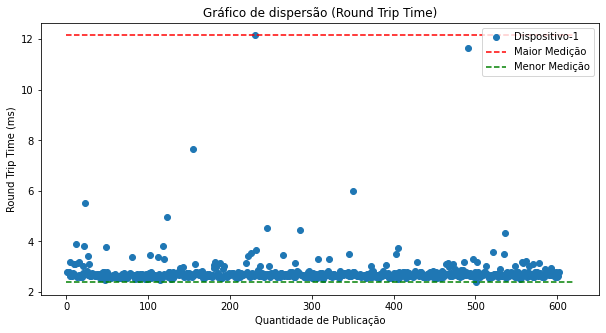

In [8]:
import matplotlib 
# matplotlib.rc('xtick', labelsize=20) 
# matplotlib.rc('ytick', labelsize=20) 
# matplotlib.rcParams.update({'font.size': 15})
i=1
fig, ax = plt.subplots(figsize=(10,5),dpi=72)
for port in ports:
  ax.scatter(data[port]["RTT"].index,data[port]["RTT"], label='Dispositivo-{}'.format(i))
  ax.set_ylabel('Round Trip Time (ms)')
  ax.set_xlabel('Quantidade de Publicação')
  ax.set_title('Gráfico de dispersão (Round Trip Time)')
  ax.hlines(data[port]["RTT"].max(),  xmin=0, xmax=620, colors="red", linestyles="dashed", label="Maior Medição")
  ax.hlines(data[port]["RTT"].min(),  xmin=0, xmax=620, colors="green", linestyles="dashed", label="Menor Medição")
  ax.legend()
  i+=1


### Analisando Dados Discrepantes(Outliers).

Analisando o gráfico acima pode-se perceber que existem dados discrepantes, esses dados são conhecidos como outliers, que são dados que diferenciam drasticamente de todos os outros.

Em outras palavras, um outlier é um valor que foge da normalidade e que pode causar anomalias nos resultados obtidos por meio de algoritmos e sistemas de análise.

Vamos analisar um gráfico que é denominado boxPlot e depois utilizaremos uma regra para limpar os outliers.

O grande objetivo é verificar a distribuição dos dados. Assim, as conclusões que tiramos ao analisar um box plot são: centro dos dados (a média ou mediana), a amplitude dos dados (máximo – mínimo), a simetria ou assimetria do conjunto de dados e a presença de outliers.

Segue uma imagem abaixo que representa um boxplot. Iremos utilizar um conceito estatistico denominado intervalos interquartils

![alt text](../../Documentation/docs/image/boxplotinfo.png)


Uma regra bastante usada afirma que um dado é um outlier quando ele é maior que $1{,}5\cdot \text{FIQ}$ acima do terceiro quartil ou abaixo do primeiro quartil. 


$$ {FIQ} =  {Q}_3 - {Q}_1 $$
$$ LimiteInferior =  {Q}_1 - 1,5.{FIQ}$$ 
$$ LimiteSuperior =  {Q}_3 + 1,5.{FIQ}$$

Segue abaixo o gráfico boxplot referente aos nossos dados.

(2.0, 5.0)

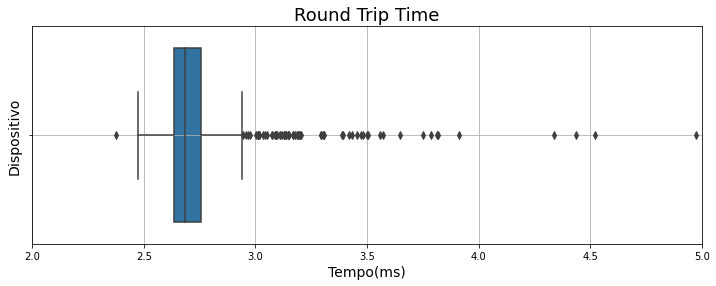

In [21]:
fig, ax = plt.subplots(figsize=(20,5),dpi=72)
ax = sns.boxplot(x = 'RTT', data = data[37953], orient = 'h')
ax.figure.set_size_inches(12, 4)
ax.set_title('Round Trip Time', fontsize=18)
ax.set_xlabel('Tempo(ms)', fontsize=14)
ax.set_ylabel('Dispositivo', fontsize=14)
ax.grid()

ax.set_xlim(2, 5)

Sabemos que a média é uma medida de tendência central que leva em consideração todos os valores de uma amostra o que é algo positivo. No entanto, como a média é sensivel a cada valor, valores extremos pode afeta-la de maneira consideravel. A média acaba não resistindo a valores extremos, portanto podemos dizer que a média não é uma medida de centro resistente. Quando nossa mediana é menor que nossa média indica uma assimetria para direita, ou seja, poucos valores de magnitude alta estão aumentando o valor da nossa média, podendo esses serem valores que são considerados outliers.

In [25]:
## Analisando outliers
df_novo = {}
for port in ports:
  data[port]
  q3, q1 = np.percentile(data[port]["RTT"], [75, 25])
  interquartil = q3 - q1
  limite_superior =q3 + 1.5 * interquartil
  limite_inferior = q1 - 1.5 * interquartil 
  df_novo[port] = data[port].loc[((data[port]["RTT"]>limite_inferior) & (data[port]["RTT"]<limite_superior))]
  dados_excluidos = data[port]["RTT"].shape[0] - len(df_novo[port])

  print("Q3", q3)
  print("Q1", q1)
  print("FIQ", interquartil)
  print("limite_superior", limite_superior)
  print("limite_inferior", limite_inferior)
  print("média nova", df_novo[port]["RTT"].mean())
  print("Média antiga", data[port]["RTT"].mean())
  print("Median", data[port]["RTT"].median())
  print("Median", df_novo[port]["RTT"].median())


Q3 2.75718175001316
Q1 2.633567499984224
FIQ 0.12361425002893611
limite_superior 2.9426031250565643
limite_inferior 2.44814612494082
média nova 2.6776537992498155
Média antiga 2.794579920265673
Median 2.6867750000008073
Median 2.676370000017414


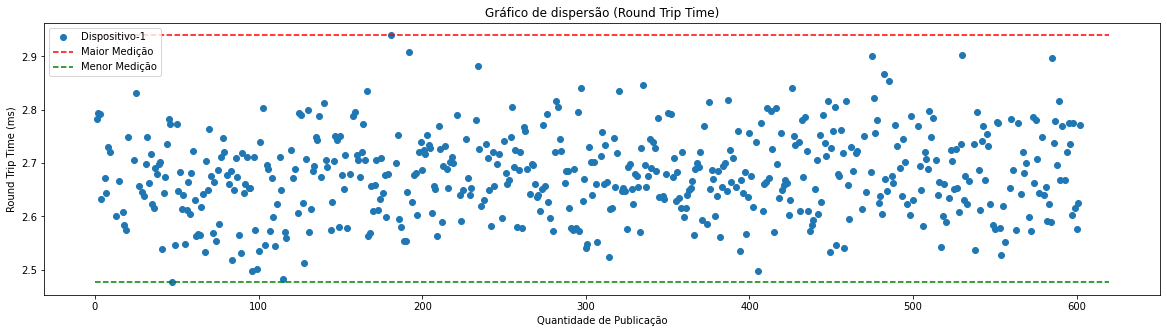

In [20]:
import matplotlib 
# matplotlib.rc('xtick', labelsize=20) 
# matplotlib.rc('ytick', labelsize=20) 
# matplotlib.rcParams.update({'font.size': 15})
i=1
fig, ax = plt.subplots(figsize=(20,5),dpi=72)
for port in ports:
  ax.scatter(df_novo[port]["RTT"].index,df_novo[port]["RTT"], label='Dispositivo-{}'.format(i))
  ax.set_ylabel('Round Trip Time (ms)')
  ax.set_xlabel('Quantidade de Publicação')
  ax.set_title('Gráfico de dispersão (Round Trip Time)')
  ax.hlines(df_novo[port]["RTT"].max(),  xmin=0, xmax=620, colors="red", linestyles="dashed", label="Maior Medição")
  ax.hlines(df_novo[port]["RTT"].min(),  xmin=0, xmax=620, colors="green", linestyles="dashed", label="Menor Medição")
  ax.legend()
  i+=1


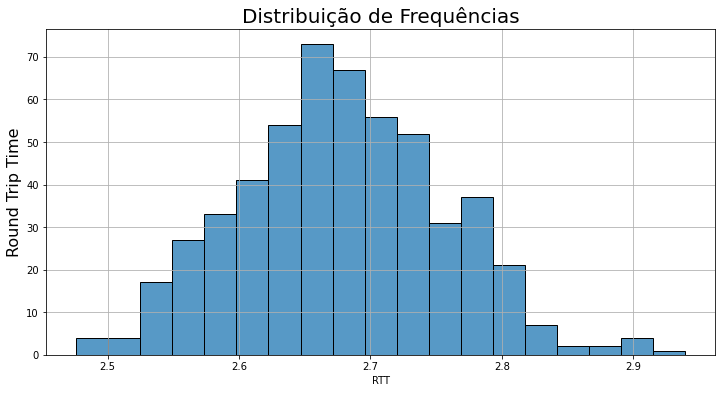

In [23]:
i=1
fig, ax = plt.subplots(figsize=(20,5),dpi=72)
for port in ports:
  ax = sns.histplot(df_novo[port]["RTT"])
  ax.figure.set_size_inches(12, 6)
  ax.set_title('Distribuição de Frequências', fontsize=20)
  ax.set_ylabel('Round Trip Time', fontsize=16)
  ax.grid()
  i+=1

# >CÁLCULO DO TAMANHO DA AMOSTRA
***
## Variáveis quantitativas e população infinita
***
## Nívéis de confiança e significância 
O **nível de confiança** ($1 - \alpha$) representa a probabilidade de acerto da estimativa. De forma complementar o **nível de significância** ($\alpha$) expressa a probabilidade de erro da estimativa.

O **nível de confiança** representa o grau de confiabilidade do resultado da estimativa estar dentro de determinado intervalo. Quando fixamos em uma pesquisa um **nível de confiança** de 95%, por exemplo, estamos assumindo que existe uma probabilidade de 95% dos resultados da pesquisa representarem bem a realidade, ou seja, estarem corretos.

O **nível de confiança** de uma estimativa pode ser obtido a partir da área sob a curva normal como ilustrado na figura abaixo.


![alt text](https://caelum-online-public.s3.amazonaws.com/1178-estatistica-parte2/01/img007.png)

Em nosso trabalho iremos utilizar um nivel de confiança de 95%, logo abaixo iremos calcular o Z.

Esta variável $Z$ representa o afastamento em desvios padrões de um valor da variável original em relação à média.

In [12]:
#variavel nível de significancia
nivel_de_significancia = 0.05

In [13]:
#Calculando nivel de confiança
nivel_de_confiança = 1 - nivel_de_significancia
nivel_de_confiança

0.95

In [14]:
#Calculando o z com scipy
z = scipy.stats.norm.ppf(0.975)
z

1.959963984540054

Com nosso z calculado podemos seguir adiante

### $$z = 1.959963984540054 $$

Abaixo segue algumas formulas que iremos utilizar para calcular o numero de amostra



## $$n = \left(z\frac{s}{e}\right)^2$$





Onde:

$z$ = variável normal padronizada

$s$ = desvio padrão amostral

$e$ = erro inferencial


### Calculando a desvio padrão $s$

In [15]:
# Calculando o desvio padrão do nosso único dispositivo
desvio_padrao_amostral = data[37953]["RTT"].std()
desvio_padrao_amostral

0.6409882996918244

### Calculando o Erro

In [16]:
#Calculando o erro da nossa amostra equivalente a 5%

media = RTT["RTT"].mean()
e = 0.05 * media
e

0.13972899601328367

### Calculando o tamanho da nossa amostra

In [17]:
# Substituindo todos os valores na formula para calcular o numero de amostra.
n = (z * (desvio_padrao_amostral/e))**2
n

80.83944240619886